# FINN - Folding
--------------------------------------
**Note: To run this notebook, you first need to run the build flow in the 3rd cybersecurity notebook as we utilize one of the intermediate models generated in that process in this notebook.** 

This notebook describes the use of FINN parallelization parameters (PE & SIMD) to efficiently streamline models so as to extract the maximum performance out of them. 

Please be aware that the folding factors can not be selected arbitrarily, each layer has constraints on which values the parallelization parameters can be set to, for more information see here: https://finn-dev.readthedocs.io/en/latest/internals.html#folding-factors

We'll use the utility function `showInNetron()` to visualize and interact with our network in the Jupyter Notebook and `showSrc()` to show source code of FINN library calls.

In [1]:
from finn.util.visualization import showInNetron, showSrc

Note: The build_flow in the cybsec_mlp notebook comprises a transformation step `step_target_fps_parallelization` that automatically sets custom parallelization parameters needed to achieve a given `target_fps` by invoking the [`SetFolding` transformation](https://github.com/Xilinx/finn/blob/main/src/finn/transformation/fpgadataflow/set_folding.py#L46).

More details of the above step can be found [here](https://github.com/Xilinx/finn/blob/main/src/finn/builder/build_dataflow_steps.py#L394).

This notebook shows the manual version of this step and explains how these attributes can improve performance and what are their effects on resource utilization for developers who need to maximize the performance of their network. 

For that we will use the `step_convert_to_hls.onnx` file as starting point. This intermediate model from the cybersecurity example is the model representation after the high-level ONNX layers are converted to HLS layers. Each node in the graph now corresponds to an HLS C++ function call and the parallelization parameters can be set using the node attributes.

We will take this model to show how to set the folding factors manually and analyze the estimated execution clock cycles and the resource utilization of each layer in the network.

### FINN-style Dataflow Architectures <a id='dataflow_arch'></a>

We start with a quick recap of FINN-style dataflow architectures. The key idea in such architectures is to parallelize across layers as well as within layers by dedicating a proportionate amount of compute resources to each layer, as illustrated in the figure below.

![](finn-dataflow.png)

In practice, the layers are instantiated by function calls to optimized Vitis HLS building blocks from the [finn-hlslib](https://github.com/Xilinx/finn-hlslib) library.

Since each layer will be instantiated, we can flexibly set the parallelization of each layer and thus control resources and throughput of our network, as visualized in the imaged below:

![](finn-folding.png)

# Part-1 : Loading the ONNX model.

As discussed above, the network needs to go through a few preparation steps before it can be fed into our estimation functions.

The `.onnx` file loaded here is taken from the cybersecurity end2end example notebook. 
We pick the onnx file `step_convert_to_hls.onnx` to which the necessary transformations have been applied for this notebook (Network layers mapped to necessary FINN-HLS blocks. In this case, the `MatrixVectorActivation` Units). 

To interact with the `.onnx` file we use the `ModelWrapper()`. This wrapper simplifies the access to different model attributes and allows us to apply custom transformations on the model.

In the below cell, we load our onnx file and view the cybersecurity MLP network in Netron.

In [2]:
from qonnx.core.modelwrapper import ModelWrapper
model = ModelWrapper("../end2end_example/cybersecurity/output_estimates_only/intermediate_models/step_convert_to_hls.onnx")
model.save("cybsec_PE_SIMD.onnx")

showInNetron("cybsec_PE_SIMD.onnx")

Serving 'cybsec_PE_SIMD.onnx' at http://0.0.0.0:5920


# Part 2 : Parallelization Parameters: PE & SIMD

The computational parallelism can be varied by setting the folding factors or also called parallelization parameters **PE** and **SIMD** of each layer. These parallelization attributes are subject to certain constraints and should be selected accordingly.

To see more details about how this is implemented in the `MatrixVectorActivation` layer (MVAU), please have a look at [this documentation](https://github.com/Xilinx/finn/blob/github-pages/docs/finn-sheduling-and-folding.pptx). A schematic of the folding in an MVAU for a fully-connected layer is shown below:

![](finn-folding-mvau.png)

In the case of the MVAU, `PE` & `SIMD` are subject to the following constraints: 

If `MW` is the number of input features and `MH` the number of output features:

        MW % SIMD == 0
        MH % PE == 0
        
Total folding in the case of the MVAU is defined as:

    Total folding = (MH/PE) x (MW/SIMD)

In a streaming dataflow architecture like it is in FINN designs the throughput is determined by the slowest layer. So, the goal of adjusting these parameters is to get an almost balanced pipeline i.e. equalizing the throughput rate of layers in the generated dataflow architecture.

The FINN compiler provides analysis passes to facilitate the exploration of the folding factors of each layer. In this notebook we will show how to use these functions and explore how the parallelization parameters affect the clock cycles and the resource utilization of the generated dataflow architecture.

We start with a naive case where `PE` & `SIMD` values across all layers are 1, this is the starting point of our exploration and is also the state the network is in after the conversion to HLS layers. If you take a look at the model using Netron and click on one of the MVAU layers, you can see that `PE` and `SIMD` are both set to 1 by default.

In [3]:
showInNetron("cybsec_PE_SIMD.onnx")

Stopping http://0.0.0.0:5920
Serving 'cybsec_PE_SIMD.onnx' at http://0.0.0.0:5920


We import the analysis passes  (`exp_cycles_per_layer()`) and  (`res_estimation()`) to estimate the number of clock cycles and resource utilization of each network layer.

In [4]:
from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.analysis.fpgadataflow.res_estimation import res_estimation

Analysis passes in FINN return information about the model in form of a dictionary, you can learn more about analysis passes in general in this Jupyter notebook: [0_custom_analysis_pass.ipynb](0_custom_analysis_pass.ipynb).

We start by calling the analysis pass `exp_cycles_per_layer()`, which returns a dictionary with the layer names as keys and the expected cycles as values. Afterwards, we plot the result in a block diagram.

In [5]:
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

{'MatrixVectorActivation_0': 38400,
 'MatrixVectorActivation_1': 4096,
 'MatrixVectorActivation_2': 4096,
 'MatrixVectorActivation_3': 64}

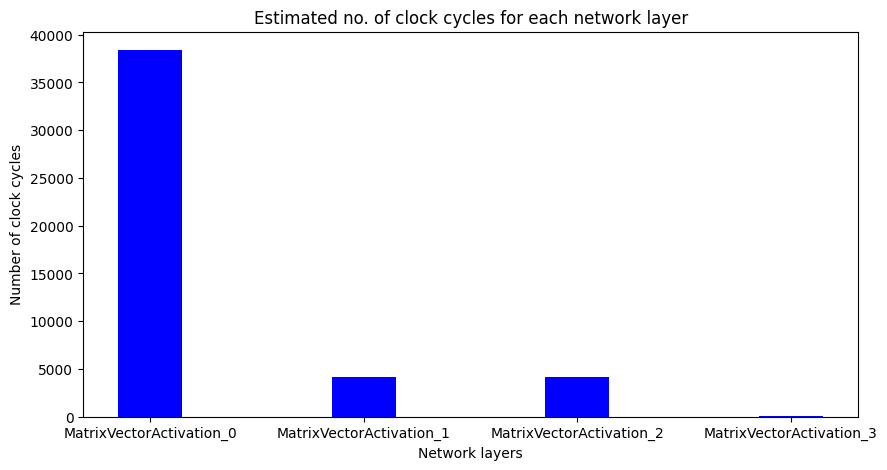

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of clock cycles")
plt.title("Estimated no. of clock cycles for each network layer")
plt.show()

We observe that the bottleneck in the execution of the model on hardware would come from the execution of the first layer which takes estimated 38400 clock cycles to execute one set of its inputs.

No matter how quickly the other layers execute, the throughput will be defined by the first layer's execution latency.

Let's have a look now at the estimated resources per layer by calling another analysis pass.
The keys are again the layer names, but the values are now a dictionary with the resource estimates per layer.

In [7]:
res_dict = model.analysis(res_estimation)
res_dict

{'MatrixVectorActivation_0': {'BRAM_18K': 5,
  'BRAM_efficiency': 0.8333333333333334,
  'LUT': 319,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_1': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_3': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.006944444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0}}

Next to the absolute numbers of LUTs, BRAM, URAM and DSPs, the analysis pass also provides information about the efficiency of the memory usage. If the memory type is not utilized, the efficiency is by default 1. You can see that above for the `URAM_efficiency`. In all other cases the efficiency indicates the actual parameter storage needed divided by the allocated BRAM/URAM storage. So, this means in our example MVAU_0 uses 5 block ram and they are 83% utilized. 

After we extract that information from the model, we plot the number of LUTs. In this notebook we concentrate on the influence on the LUT usage, but by manipulating the code below, you can also extract information about memory and dsp usage.

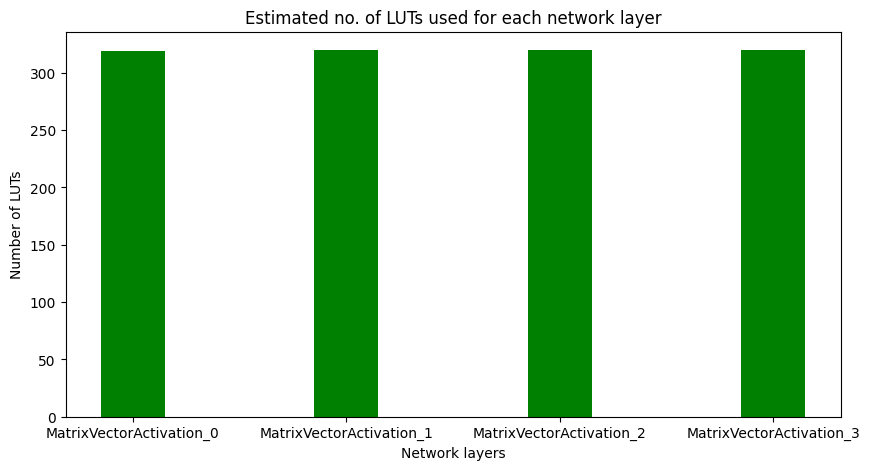

In [8]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of LUTs")
plt.title("Estimated no. of LUTs used for each network layer")
plt.show()

Since we identified above that the first layer takes the highest number of cycles to complete the execution, we will now try to adjust the folding parameters to reduce its latency at the expense of an increase in resource utilization.

## Modify Parameters

We now modify the parallelization parameters of the first network layer to reduce its overall latency.
We individually extract the `MatrixVectorActivation` blocks from the `.onnx` file and set the config values manually (although this can be done automatically by the FINN compiler as mentioned in the introduction).

In the first step, we left the `PE` & `SIMD` values for all the layers on default (=1) to establish a baseline and measure the estimated clock cycles and resource utilization for each of the individual layers.

To set `PE` & `SIMD`, we will utilize functionality from the FINN compiler. Each layer type has a Python wrapper which can be instantiated using the `getCustomOp()` function. The wrapper offers several helper functions like `get_nodeattr()` and `set_nodeattr()` to access and set the attributes of a node.

In [9]:
from qonnx.custom_op.registry import getCustomOp

list_of_mvaus = model.get_nodes_by_op_type("MatrixVectorActivation")
mvau0 = list_of_mvaus[0]

mvau0_inst = getCustomOp(mvau0)

# Get the node attributes to check the current setting
print("The parallelization parameters of %s were: " % mvau0.name)
print("PE: " + str(mvau0_inst.get_nodeattr("PE")))
print("SIMD: " + str(mvau0_inst.get_nodeattr("SIMD")))

# Set the new node attributes
mvau0_inst.set_nodeattr("PE", 2)
mvau0_inst.set_nodeattr("SIMD", 5)

# Get the node attributes to check the updated setting
print("The parallelization parameters of %s are updated to: " % mvau0.name)
print("PE: " + str(mvau0_inst.get_nodeattr("PE")))
print("SIMD: " + str(mvau0_inst.get_nodeattr("SIMD")))

The parallelization parameters of MatrixVectorActivation_0 were: 
PE: 1
SIMD: 1
The parallelization parameters of MatrixVectorActivation_0 are updated to: 
PE: 2
SIMD: 5


We save the model and view it. On expanding the first `MatrixVectorActivation` we can view the updated `PE` & `SIMD` parameters for that layer.

In [10]:
model.save("cybsec_PE_SIMD_modified.onnx")
showInNetron("cybsec_PE_SIMD_modified.onnx")

Stopping http://0.0.0.0:5920
Serving 'cybsec_PE_SIMD_modified.onnx' at http://0.0.0.0:5920


From the above total folding formula, we have reduced the total folding of our layer from `600 x 64` to `120 x 32`. Hence, resulting in an estimated `10x` decrease in the execution latency of our layer. 
This can be observed in the new estimated clock cycles.

In [12]:
cycles_dict_updated = model.analysis(exp_cycles_per_layer)
cycles_dict_updated

{'MatrixVectorActivation_0': 3840,
 'MatrixVectorActivation_1': 4096,
 'MatrixVectorActivation_2': 4096,
 'MatrixVectorActivation_3': 64}

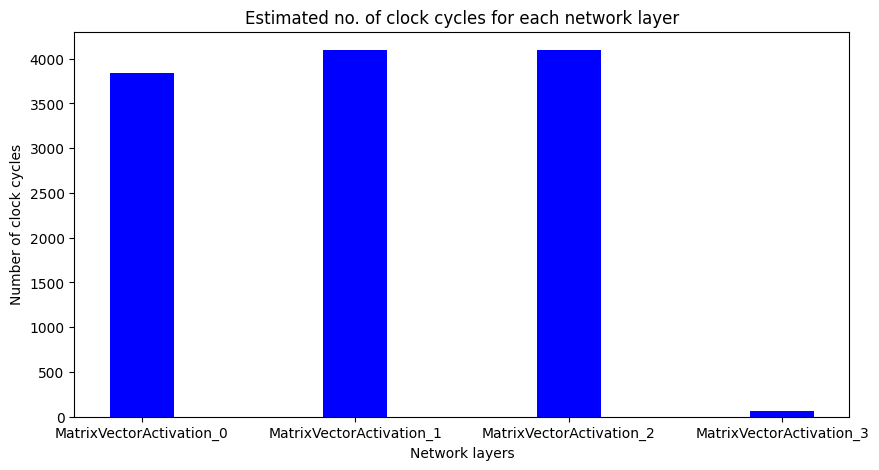

In [13]:
fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict_updated.keys(), cycles_dict_updated.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of clock cycles")
plt.title("Estimated no. of clock cycles for each network layer")
plt.show()

In [14]:
res_dict_updated = model.analysis(res_estimation)
res_dict_updated

{'MatrixVectorActivation_0': {'BRAM_18K': 8,
  'BRAM_efficiency': 0.5208333333333334,
  'LUT': 418,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_1': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_3': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.006944444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0}}

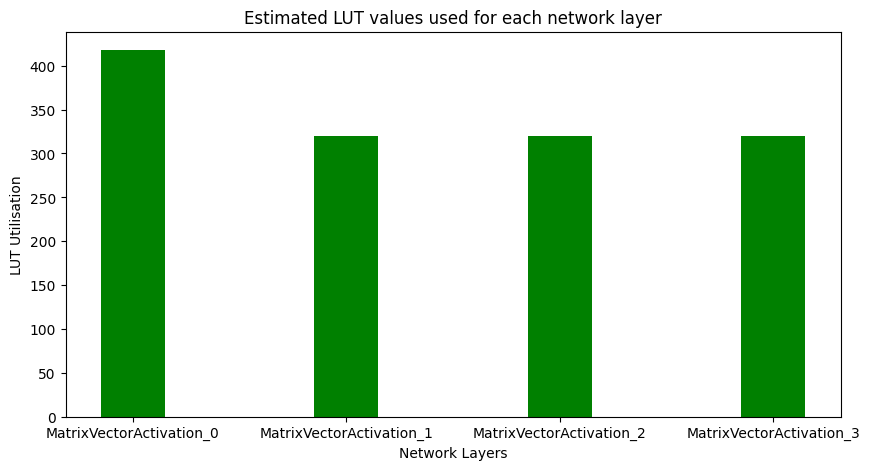

In [16]:
# Extracting LUTs from res_dict
LUTs_updated = [res_dict_updated[key]["LUT"] for key in res_dict_updated.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict_updated.keys(), LUTs_updated, color ='green', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

From these numbers, we see that the first layer has been removed as the bottleneck and that the entire network can now perform one inference in ~4096 clock cycles (when the pipeline is full) as compared to the earlier configuration where it took ~38400 execution cycles.

This decrease in execution latency of the network though comes at a cost of a 45% increase in LUT resource utilization for layer 1 of the network.

# Important Note : StreamingDataWidthConverters

Next to resources and performance, folding factors (or parallelization parameters) are influencing also other properties of the generated design. Since we are able to generate results in parallel, the data that gets feed into the layer needs to be packed in a specific format to provide the correct data at the correct time for the internal parallelism. Also, the data that comes out of a layer will be in a specific format depending on the internal parallelism.

To analyze the influence of the folding factors on the data streams between layers, we first will import the original model (with `PE=SIMD=1`) and then we will import the updated model, so that we can compare the two of them.

In [17]:
model_orig = ModelWrapper("cybsec_PE_SIMD.onnx")
model_updated = ModelWrapper("cybsec_PE_SIMD_modified.onnx")

In the next step we extract the information from all layers. For MVAUs the input shape is (1, MW/SIMD, SIMD) and the output shape is (1, MH/PE, PE).

In [25]:
# Original model
list_of_mvaus = model_orig.get_nodes_by_op_type("MatrixVectorActivation")
print("In the original model (pe=simd=1): ")
for mvau in list_of_mvaus:
    mvau_inst = getCustomOp(mvau)
    print("Layer: " + mvau.name)
    print("Input shape: " + str(mvau_inst.get_folded_input_shape()))
    print("Output shape: " + str(mvau_inst.get_folded_output_shape()))

In the original model (pe=simd=1): 
Layer: MatrixVectorActivation_0
Input shape: (1, 600, 1)
Output shape: (1, 64, 1)
Layer: MatrixVectorActivation_1
Input shape: (1, 64, 1)
Output shape: (1, 64, 1)
Layer: MatrixVectorActivation_2
Input shape: (1, 64, 1)
Output shape: (1, 64, 1)
Layer: MatrixVectorActivation_3
Input shape: (1, 64, 1)
Output shape: (1, 1, 1)


In [26]:
# Updated model
list_of_mvaus = model_updated.get_nodes_by_op_type("MatrixVectorActivation")
print("In the original model (pe=simd=1): ")
for mvau in list_of_mvaus:
    mvau_inst = getCustomOp(mvau)
    print("Layer: " + mvau.name)
    print("Input shape: " + str(mvau_inst.get_folded_input_shape()))
    print("Output shape: " + str(mvau_inst.get_folded_output_shape()))

In the original model (pe=simd=1): 
Layer: MatrixVectorActivation_0
Input shape: (1, 120, 5)
Output shape: (1, 32, 2)
Layer: MatrixVectorActivation_1
Input shape: (1, 64, 1)
Output shape: (1, 64, 1)
Layer: MatrixVectorActivation_2
Input shape: (1, 64, 1)
Output shape: (1, 64, 1)
Layer: MatrixVectorActivation_3
Input shape: (1, 64, 1)
Output shape: (1, 1, 1)


We can see that the input and output shape for MatrixVectorActivation_0 has changed after we have changed the folding factors. These changes have direct influence on the in/out stream width. We can have a closer look at the formula to calculate the stream width of an MVAU.

In [30]:
showSrc(mvau_inst.get_instream_width)

    def get_instream_width(self, ind=0):
        i_bits = self.get_input_datatype().bitwidth()
        in_width = i_bits * self.get_nodeattr("SIMD")
        return in_width



In [31]:
showSrc(mvau_inst.get_outstream_width)

    def get_outstream_width(self, ind=0):
        o_bits = self.get_output_datatype().bitwidth()
        out_width = o_bits * self.get_nodeattr("PE")
        return out_width



The input stream width can be calculated by multiplying the input bit width with SIMD and the output stream width can be calculated by multiplying the output bit width with PE.

To connect two layers with each other for the final design, the input stream width of a node needs to match the output stream width of the preceding node. If that is not the case FINN inserts DataWidthConverters (DWCs) to resolve this mismatch. Let's have a look at the input/output stream width of the layers before updating the parallelization parameters.

In [32]:
# Original model
list_of_mvaus = model_orig.get_nodes_by_op_type("MatrixVectorActivation")
print("In the original model (pe=simd=1): ")
for mvau in list_of_mvaus:
    mvau_inst = getCustomOp(mvau)
    print("Layer: " + mvau.name)
    print("Input stream width: " + str(mvau_inst.get_instream_width()))
    print("Output stream width: " + str(mvau_inst.get_outstream_width()))

In the original model (pe=simd=1): 
Layer: MatrixVectorActivation_0
Input stream width: 1
Output stream width: 2
Layer: MatrixVectorActivation_1
Input stream width: 2
Output stream width: 2
Layer: MatrixVectorActivation_2
Input stream width: 2
Output stream width: 2
Layer: MatrixVectorActivation_3
Input stream width: 2
Output stream width: 1


In the original model the output stream width of one layer matches the input stream width of the following layer. So there would be no DWC required when generating the final design.

For the updated model, the situation is different. Let's have a look how the stream widths have changed.

In [34]:
# Updated model
list_of_mvaus = model_updated.get_nodes_by_op_type("MatrixVectorActivation")
print("In the original model (pe=simd=1): ")
for mvau in list_of_mvaus:
    mvau_inst = getCustomOp(mvau)
    print("Layer: " + mvau.name)
    print("Input stream width: " + str(mvau_inst.get_instream_width()))
    print("Output stream width: " + str(mvau_inst.get_outstream_width()))

In the original model (pe=simd=1): 
Layer: MatrixVectorActivation_0
Input stream width: 5
Output stream width: 4
Layer: MatrixVectorActivation_1
Input stream width: 2
Output stream width: 2
Layer: MatrixVectorActivation_2
Input stream width: 2
Output stream width: 2
Layer: MatrixVectorActivation_3
Input stream width: 2
Output stream width: 1


As we can see, the output stream width of MatrixVectorActivation_0 has now changed to `4`, while the input stream width of MatrixVectorActivation_1 stayed `2`. So, the FINN compiler would insert a DWC between these nodes, we can manually invoke this behavior by calling the transformation `InsertDWC` on our model.

In [39]:
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from qonnx.transformation.general import GiveUniqueNodeNames

model_updated = model_updated.transform(InsertDWC())
model_updated = model_updated.transform(GiveUniqueNodeNames())

In [40]:
model_updated.save("cybsec_DWC.onnx")
showInNetron("cybsec_DWC.onnx")

Stopping http://0.0.0.0:5920
Serving 'cybsec_DWC.onnx' at http://0.0.0.0:5920


We can observe in the model that a DWC was inserted between the first two layers.
Since the DWC will also be a hardware block in our final FINN design, it has a latency and resources associated with it. Let's have a final look in our resource estimates.

In [42]:
model_dwc = ModelWrapper("cybsec_DWC.onnx")
res_dict_dwc = model_dwc.analysis(res_estimation)
res_dict_dwc

{'MatrixVectorActivation_0': {'BRAM_18K': 8,
  'BRAM_efficiency': 0.5208333333333334,
  'LUT': 418,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingDataWidthConverter_Batch_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 3,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_1': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_3': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.006944444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0}}

Since we have now one additional layer, we manipulate the data to shorten the layer names in the plot.

In [48]:
layers = res_dict_dwc.keys()
# replace names of layers with abbreviations
layers = [n.replace("MatrixVectorActivation_", "MVU") for n in layers]
layers = [n.replace("StreamingDataWidthConverter_Batch", "DWC") for n in layers]

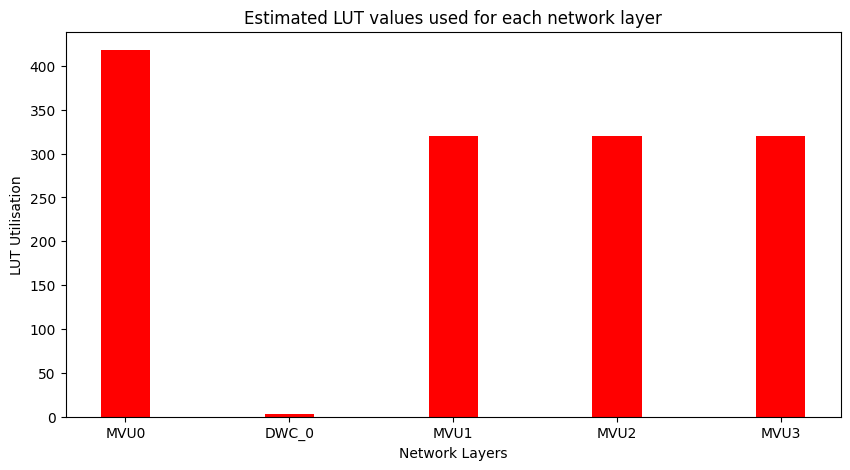

In [50]:
# Extracting LUTs from res_dict
LUTs_dwc = [res_dict_dwc[key]["LUT"] for key in res_dict_dwc.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(layers, LUTs_dwc, color ='red', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

In the case of our example network, the `StreamingDataWidthConverter_Batch` layer does not consume a large number of LUT resources as shown in the graph. This might be different for larger models and if there are a higher number of DWCs inserted. Please be aware of this when setting the folding factors for your network.